
# Diseño de software para cómputo científico

----

## Unidad 5: Integración con lenguajes de alto nivel con bajo nivel.


## Agenda de la Unidad 5

- JIT (Numba)
- Cython.
- Integración de Python con FORTRAN.
- **Integración de Python con C.**


## Recapitulando

- Escribimos el código Python.
- Pasamos todo a numpy.
- Hicimos profile.
- Paralelisamos (joblib/dask).
- Hicimos profile.
- Usamos Numba.
- Hicimos profile.
- Si podemos elegir el lenguaje: Cython
    - Si no podemos elegir el lenguaje y vamos a hacer cómputo numérico FORTRAN.
- Si no podemos elegir vamos con C/C++/Rust/lo-que-sea.


## Ctypes

- Permite usar bibliotecas existentes en otros idiomas escribiendo envoltorios **simples** en Python.
- Viene con Python.
- Puede ser un poco **Dificil** de usar.
- Es una herramienta ideal para comper Python

### Ejemplo para Ctypes 1/2

El código C que usaremos en este tutorial está diseñado para ser lo más simple posible mientras demuestra los conceptos que estamos cubriendo. Es más un "ejemplo de juguete" y no pretende ser útil por sí solo. Estas son las funciones que utilizaremos:

```c
int simple_function(void) {
    static int counter = 0;
    counter++;
    return counter;
}
```

- `simple_function` simplemente devuelve números de conteo. 
- Cada vez que se llama en incrementos de contador y devuelve ese valor.

### Ejemplo para Ctypes 2/2

```c
void add_one_to_string(char *input) {
    int ii = 0;
    for (; ii < strlen(input); ii++) {
        input[ii]++;
    }
}
```

- Agrega uno a cada carácter en una matriz de caracteres que se pasa. 
- Usaremos esto para hablar sobre las cadenas inmutables de Python y cómo solucionarlas cuando sea necesario.

Estos ejemplos estan guardadoe en `clibc1.c`, y se compilan con:

```bash
gcc -c -Wall -Werror -fpic clib1.c # crea el código objeto
gcc -shared -o libclib1.so clib1.o # crea el .so
```


## Llamando a una función simple

In [1]:
import ctypes

# Load the shared library into c types.
libc = ctypes.CDLL("ctypes/libclib1.so")

In [8]:
counter = libc.simple_function()
counter

7

## Cadenas inmutables en Python con Ctypes

In [9]:
print("Calling C function which tries to modify Python string")
original_string = "starting string"
print("Before:", original_string)

# This call does not change value, even though it tries!
libc.add_one_to_string(original_string)

print("After: ", original_string)

Calling C function which tries to modify Python string
Before: starting string
After:  starting string


- Como notarán esto **no anda**.
- El `original_string` no está disponible en la función C en absoluto al hacer esto. 
- La función C modificó alguna otra memoria, no la cadena. 
- La función C no solo no hace lo que desea, sino que también modifica la memoria que no debería, lo que genera posibles problemas de corrupción de memoria.
- Si queremos que la función C tenga acceso a la cadena, necesitamos hacer un poco de trabajo de serialización.

## Cadenas inmutables en Python con Ctypes

- Necesitamos convertir la cadena original a bytes usando `str.encode,` y luego pasar esto al constructor para un `ctypes.string_buffer`. 
- Los String_buffers son mutables y se pasan a C como `char *`.

In [10]:
# The ctypes string buffer IS mutable, however.
print("Calling C function with mutable buffer this time")

# Need to encode the original to get bytes for string_buffer
mutable_string = ctypes.create_string_buffer(str.encode(original_string))

print("Before:", mutable_string.value)
libc.add_one_to_string(mutable_string)  # Works!
print("After: ", mutable_string.value)

Calling C function with mutable buffer this time
Before: b'starting string'
After:  b'tubsujoh!tusjoh'


## Especificación de firmas de funciones en ctypes

- Como vimos anteriormente, podemos especificar el tipo de retorno si es necesario.
- Podemos hacer una especificación similar de los parámetros de la función. 
- Además, proporcionar una firma de función le permite a Python verificar que está pasando los parámetros correctos cuando llama a una función C, de lo contrario, pueden suceder cosas **malas**.

Para especificar el tipo de retorno de una función, hayque obtener el bjeto de la función y establecer la propiedad `restype`:

```python
libc.func.restype = ctypes.POINTER(ctypes.c_char)
```

y para especificar las firmas

```python
libc.func.argtypes = [ctypes.POINTER(ctypes.c_char), ]
```

## Escribir una interfaz  Python en C

Vamos a "envolver" función de biblioteca C `fputs()`:

```C
int fputs (const char *, FILE *)
```

- Esta función toma dos argumentos:
    1. `const char *` es una matriz de caracteres.
    2. `FILE *` es un puntero a un stream de archivo.
- `fputs()` escribe la matriz de caracteres en el archivo especificado y devuelve un valor no negativo, si la operación es exitosa, este valor indicará el número de bytes escritos en el archivo. 
- Si hay un error, entonces devuelve `EOF`. 

## Escribir la función C para `fputs()`

Este es un programa básico de C que usa fputs() para escribir una cadena en una secuencia de archivos:

```C
#include <stdio.h>
#include <stdlib.h>
#include <unistd.h>

int main() {
    FILE *fp = fopen("write.txt", "w");
    fputs("Real Python!", fp);
    fclose(fp);
    return 1;
}
```

## Envolviendo `fputs()`

El siguiente bloque de código muestra la versión final envuelta de su código C:

```C
#include <Python.h>

static PyObject *method_fputs(PyObject *self, PyObject *args) {
    char *str, *filename = NULL;
    int bytes_copied = -1;

    /* Parse arguments */
    if(!PyArg_ParseTuple(args, "ss", &str, &filename)) {
        return NULL;
    }

    FILE *fp = fopen(filename, "w");
    bytes_copied = fputs(str, fp);
    fclose(fp);

    return PyLong_FromLong(bytes_copied);
}
```

Este fragmento de código hace referencia a tres estructuras de objetos que se definen en `Python.h`:
`PyObject`, `PyArg_ParseTuple()` y `PyLong_FromLong()`

## `PyObject`

- `PyObject` es una estructura de objetos que utiliza para definir tipos de objetos para Python. 
- Todos los demás tipos de objetos Python son extensiones de este tipo.
- Establecer el tipo de retorno de la función anterior como `PyObject` define los campos comunes que requiere Python para reconocer esto como un tipo válido.

Eche otro vistazo a las primeras líneas de su código C:

```C
static PyObject *method_fputs(PyObject *self, PyObject *args) {
    char *str, *filename = NULL;
    int bytes_copied = -1;
    ...
```   

En la línea 2, declara los tipos de argumento que desea recibir de su código Python:

- `char *str` es la cadena que desea escribir en la secuencia del archivo.
- `char *filename` es el nombre del archivo para escribir.

## `PyArg_ParseTuple()`

`PyArg_ParseTuple()` transforma los argumentos que recibirá de su programa Python en variables locales:

```C
static PyObject *method_fputs(PyObject *self, PyObject *args) {
    char *str, *filename = NULL;
    int bytes_copied = -1;
    
    if(!PyArg_ParseTuple(args, "ss", &str, &filename)) {
        return NULL;
    }
    ...
``` 

`PyArg_ParseTuple()` toma los siguientes argumentos:

- `args` de tipo `PyObject`.
- `"ss"` especifica el tipo de datos de los argumentos a analizar.
- `&str` y `&filename` son punteros a variables locales a las que se asignarán los valores analizados.

`PyArg_ParseTuple()` retorna `false` frente a un error.

## `fputs()` y `PyLongFromLon()`

```C
static PyObject *method_fputs(PyObject *self, PyObject *args) {
    char *str, *filename = NULL;
    int bytes_copied = -1;
    if(!PyArg_ParseTuple(args, "ss", &str, &filename)) {
        return NULL;
    }

    FILE *fp = fopen(filename, "w");
    bytes_copied = fputs(str, fp);
    fclose(fp);

    return PyLong_FromLong(bytes_copied);
}

``` 

- Las llamadas a `fputs()` fueron explicadas anteriormente, la única diferencia es que las variables utilizadas son las que provienen de `*args` y almacenadas localmente.
- Finalmente `PyLong_FromLong()` retorna un `PyLongObject`, que representa objecto entero en Python.

## Módulo de extensión

Ya se escribió el código que constituye la funcionalidad principal de su módulo de extensión Python C. 
- Sin embargo queda escribir las definiciones de su módulo y los métodos que contiene, de esta manera:

```C
static PyMethodDef FputsMethods[] = {
    {"fputs", method_fputs, METH_VARARGS, "Python interface for fputs C library function"},
    {NULL, NULL, 0, NULL}
};


static struct PyModuleDef fputsmodule = {
    PyModuleDef_HEAD_INIT,
    "fputs",
    "Python interface for the fputs C library function",
    -1,
    FputsMethods
};
```

## `PyMethodDef`


- `PyMethodDef` informa al intérprete de Python sobre ello  los métodos definidos en el módulo
- Idealmente, habrá más de un método en la. Es por eso que necesita definir una matriz de estructuras:

```C
static PyMethodDef FputsMethods[] = {
    {"fputs", method_fputs, METH_VARARGS, "Python interface for fputs C library function"},
    {NULL, NULL, 0, NULL}
};
```

Cada miembro individual de la estructura contiene la siguiente información:
- `fputs` es el nombre que el usuario escribiría para invocar esta función en particular desde Python.
- `method_fputs` es el nombre de la función C a invocar.
- `METH_VARARGS` indica que la función aceptará dos argumentos de tipo
`PyObject *`:
    - `self` es el objeto del módulo.
    - `args` es una tupla que contiene los argumentos de la función (descomprimibles `PyArg_ParseTuple()`.
- La cadena final es un valor para representar el docstring.

### `PyModuleDef`

Define un módulo Python (un archivo `.py`) en C.

```C
static struct PyModuleDef fputsmodule = {
    PyModuleDef_HEAD_INIT, "fputs",
    "Interface for the fputs C function", -1, FputsMethods};```

Hay un total de 9 miembros en esta estructura, pero  el bloque de código anterior, inicializa los siguientes cinco:

- `PyModuleDef_HEAD_INIT` es la clase "base" del módulo (normalmente esto siempre es igual).
- `"fputs"` nombre del módulo.
- La cadena es la documentación del módulo.
- `-1`  cantidad de memoria necesaria para almacenar el estado del programa. Es útil cuando su módulo se utiliza en múltiples subinterpretadores, y puede tener los siguientes valores:
    - Un valor negativo indica que este módulo no tiene soporte para subinterpretadores.
    - Un valor no negativo permite la reinicialización del módulo. También especifica el requisito de memoria que se asignará en cada sesión de subinterpretador.
- `FputsMethods` es tabla de métodos. 

## Inicializando el módulo

- Ahora que ha definido la extensión Python C y las estructuras de métodos, es hora de ponerlas en uso. 
- Cuando un programa Python importa su módulo por primera vez, llamará a `PyInit_fputs()`:

```C
PyMODINIT_FUNC PyInit_fputs(void) {
    return PyModule_Create(&fputsmodule);
}
``` 

`PyMODINIT_FUNC hace 3 cosas implícitamente`

- Establece implícitamente el tipo de retorno de la función como PyObject *.
- Declara cualquier enlace especial.
- Declara la función como "C" externa. En caso de que esté usando C++, le dice al compilador de C ++ que no haga cambios de nombre en los símbolos.

`PyModule_Create()` devolverá un nuevo objeto de módulo de tipo `PyObject *`.

## Poniendo todo junto - Qué pasa cuando importamos el módulo?

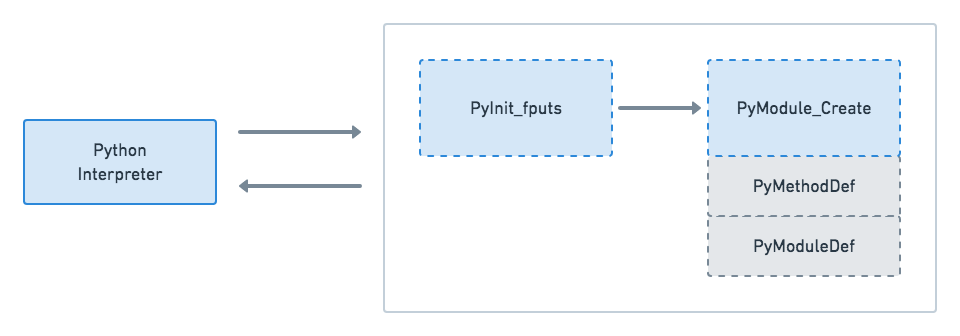

## Poniendo todo junto - Qué retorna cuando se importa el módulo?

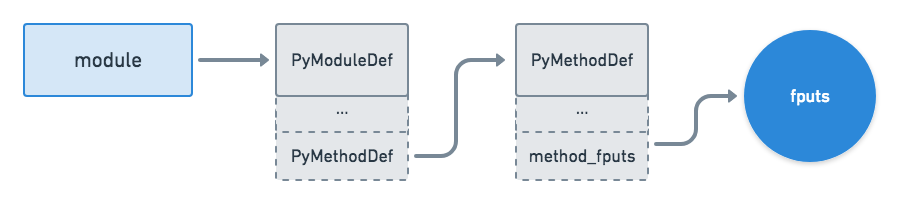

## Poniendo todo junto - Qué sucede cuando llamamos a `fputs.fputs()`

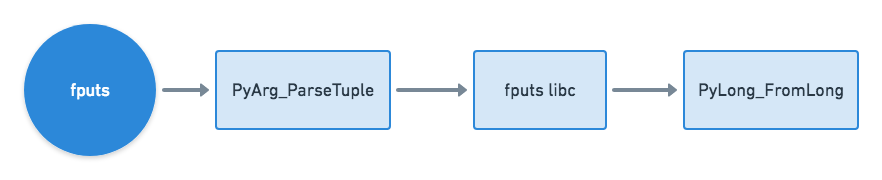

## Empaquetado con `distutils` 

```python
from distutils.core import setup, Extension

def main():
    setup(name="fputs",
          ext_modules=[Extension("fputs", ["fputsmodule.c"])],
          ...)

if __name__ == "__main__":
    main()
    
```

Para instalar:

```bash
$ python3 setup.py install 
```

Para compilar

```bash
$ python setup.py build_ext --inplace
```

Si se quiere especificar el compilador

```bash
$ CC=gcc python3 setup.py install
```

## Usando la extensión

In [1]:
import sys; sys.path.insert(0, "./c_extensions")
import fputs

In [7]:
fputs?

In [8]:
fputs.fputs?

In [9]:
fputs.fputs("Hola mundo!", "salida.txt")

1

In [10]:
with open("salida.txt") as fp: 
    print(fp.read())

Hola mundo!


## Raising Exceptions

- Si desea lanzar excepciones de Python desde  C, puede usar la API de Python para hacerlo. 
- Algunas de las funciones proporcionadas por la API de Python para generar excepciones son las siguientes:

- `PyErr_SetString(PyObject *type, const char *message)`
- `PyErr_Format(PyObject *type, const char *format)`
- `PyErr_SetObject(PyObject *type, PyObject *value)`

Todas las exceptions de Python estan definidas en las API.

## Raising Exceptions


```C
static PyObject *method_fputs(PyObject *self, PyObject *args) {
    char *str, *filename = NULL;
    int bytes_copied = -1;

    /* Parse arguments */
    if(!PyArg_ParseTuple(args, "ss", &str, &fd)) {
        return NULL;
    }
    if (strlen(str) <= 0) {
        PyErr_SetString(PyExc_ValueError, "String length must be greater than 0");
        return NULL;
    }

    fp = fopen(filename, "w");
    bytes_copied = fputs(str, fp);
    fclose(fp);

    return PyLong_FromLong(bytes_copied);
}
```

## Raising Custom Exceptions

Para crear y usar excepción personalizada, se debe agregarla instancia de módulo:

```C
static PyObject *StringTooShortError = NULL;

PyMODINIT_FUNC PyInit_fputs(void) {
    /* Assign module value */
    PyObject *module = PyModule_Create(&fputsmodule);
    /* Initialize new exception object */
    StringTooShortError = PyErr_NewException("fputs.StringTooShortError", NULL, NULL);
    /* Add exception object to your module */
    PyModule_AddObject(module, "StringTooShortError", StringTooShortError);

    return module;
}
static PyObject *method_fputs(PyObject *self, PyObject *args) {
    ...
    if (strlen(str) <=0 10) {
        /* Passing custom exception */
        PyErr_SetString(StringTooShortError, "String length must be greater than 0");
        return NULL;}
    ...
}
    
```

## Referencias

- https://docs.python.org/3.8/library/ctypes.html
- https://dbader.org/blog/python-ctypes-tutorial
- https://realpython.com/build-python-c-extension-module/